<a href="https://colab.research.google.com/github/kussy29/machine_learning/blob/main/lab02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: EM Clustering in 2D**
-------------------------------

You have seen how the **Expectation-Maximization (EM)** algorithm can fit a Gaussian Mixture Model (GMM) to a 2D dataset. You should now explore:

## **Primary Question**

**How can we visualize the *decision boundary* for attributing a *new* (unlabeled) point to one of the GMM clusters?**  

In other words, given a 2D data distribution modeled by EM, think of a way to clearly show (on a plot) *which* cluster a point would be assigned to (or which cluster has the highest responsibility (posterior probability) for that point)?  

The plot should comprehensively cover the entire visible region, ensuring that for any point on the plot, it is immediately evident which cluster it would belong to. You can plot **lines** separating clusters or use a **color map** showing each point's "most likely cluster".

You can illustrate your approach with **the same** 2D dataset that we used in class, or you can find another suitable 2D dataset, it's up to you. Note however, that having 3 clusters enhances the clarity of the visualization—while 2 clusters result in overly simple boundaries, using 4 or more clusters can make the entire plot difficult to interpret. Try to choose a dataset with 3 clusters.

Discuss any irregularities observed in the resulting plot. If a decision boundary suggests that a region should be attributed to a cluster in a counterintuitive way (we saw it in class!), provide an explanation for why this might occur. It may be also an indication you have a bug in your code.

## **Secondary Question**

**If we *didn't know* the number of clusters in advance, how could we decide on a suitable $K$ for the clustering algorithm?**  

You can illustrate your approach with **the same** dataset as in the primary question by trying different values of $K$ (and optionally plotting the evaluation metric values, e.g. silhouette scores, etc.). Or you can find another suitable dataset, it's up to you. Note, that the dataset doesn't need to be 2D in this task.

## **Task & Deliverables**

1. **Colab Notebook**  
   - Create a **Colab notebook** that:
     - Clearly **answers** both the **primary** and **secondary** questions with appropriate plots and short explanations.
     - Uses Python code (e.g. `scikit-learn` for GMM) to visualize:
       1. The **data** and **cluster assignments**.
       2. The **decision boundary** (lines or a color map) indicating each cluster's region.
       3. A demonstration (chart or table) of how you would pick a suitable number of clusters $K$ when it is not known.
   - Remember to use the `$` symbol to delimit **inline equations** and `$$` to delimit **full-line equations**.

2. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------------------------------------------------
# SECTION 1: Generate the "mouse" dataset
# ----------------------------------------------------------------------
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
data_X = np.vstack([data1, data2, data3])
N, d = data_X.shape  # should be (500, 2)

# ----------------------------------------------------------------------
# SECTION 2: Initialize EM for 3 Gaussian mixtures
# ----------------------------------------------------------------------
K = 3
np.random.seed(42)  # again for reproducibility

# Mixture weights, means, covariances
pi = np.ones(K) / K
mu = np.random.randn(K, d)
Sigma = np.array([np.eye(d) for _ in range(K)])

# ----------------------------------------------------------------------
# SECTION 3: Define functions for E-step & M-step
# ----------------------------------------------------------------------
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian pdf value at x, given mean and cov.
    x is (d, ) vector, mean is (d, ), cov is (d, d).
    """
    d_ = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / np.sqrt((2*np.pi)**d_ * det_cov)
    diff = x - mean
    exponent = -0.5 * (diff @ inv_cov @ diff.T)
    return norm_const * np.exp(exponent)

def e_step(data, pi, mu, Sigma):
    """
    E-step: compute the responsibilities resp[n, k] = p(z_n=k | x_n, theta).
    """
    N, _ = data.shape
    K = len(pi)
    resp = np.zeros((N, K))

    for n in range(N):
        for k in range(K):
            resp[n, k] = pi[k] * gaussian_pdf(data[n], mu[k], Sigma[k])
        resp[n, :] /= np.sum(resp[n, :])  # normalize

    return resp

def m_step(data, resp):
    """
    M-step: given responsibilities, update pi, mu, Sigma.
    """
    N, d_ = data.shape
    K = resp.shape[1]

    Nk = np.sum(resp, axis=0)  # shape (K,)

    # Update pi
    pi_new = Nk / N

    # Update mu
    mu_new = np.zeros((K, d_))
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k].reshape(-1,1)*data, axis=0) / Nk[k]

    # Update Sigma
    Sigma_new = []
    for k in range(K):
        S_k = np.zeros((d_, d_))
        for n in range(N):
            diff = data[n] - mu_new[k]
            S_k += resp[n, k] * np.outer(diff, diff)
        S_k /= Nk[k]
        Sigma_new.append(S_k)
    Sigma_new = np.array(Sigma_new)

    return pi_new, mu_new, Sigma_new

for i in range(100):
      resp = e_step(data_X, pi, mu, Sigma)
      pi, mu, Sigma = m_step(data_X, resp)


In [ ]:
x=np.linspace(-1.5,1.5,500)
y=np.linspace(-1.5,1.5,500)
X,Y=np.meshgrid(x,y)
resps=[]

for i in range(K):
  Z=np.zeros([len(y),len(x)])
  for j in range(len(x)):
    for k in range(len(y)):
      Z[k,j]=pi[i] *gaussian_pdf(np.array([x[j],y[k]]), mu[i], Sigma[i])
  resps.append(Z)


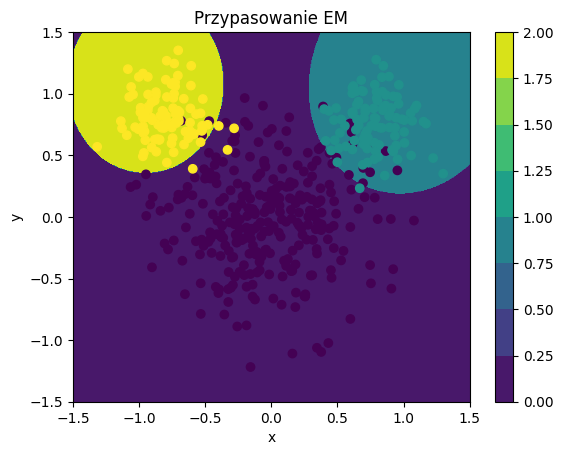

In [ ]:
przypasowanie=np.argmax(resps,axis=0)
prawda=[0]*300+[1]*100+[2]*100
plt.contourf(X,Y,przypasowanie)
plt.colorbar()
plt.scatter(data_X[:,0],data_X[:,1],c=prawda,cmap='viridis')
plt.title('Przypasowanie EM')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Question 2

We will perform for mouse data 2 types of clusstering: EM and KMeans for 2-7 clusters and we will look at silhouett scores and inertias to determine which number of clusters is best.

### EM

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

def inertia(data, labels, centroids):
    distances = pairwise_distances(data, centroids)
    min_distances = np.min(distances, axis=1)
    return np.sum(min_distances**2)


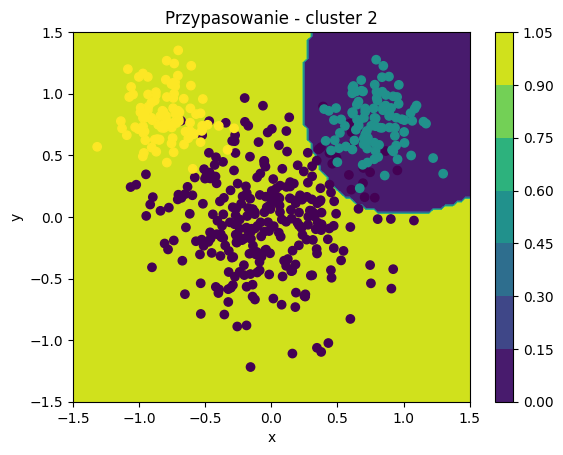

Silhouette score:  0.40890256209377435
Inertia:  186.76047427914773


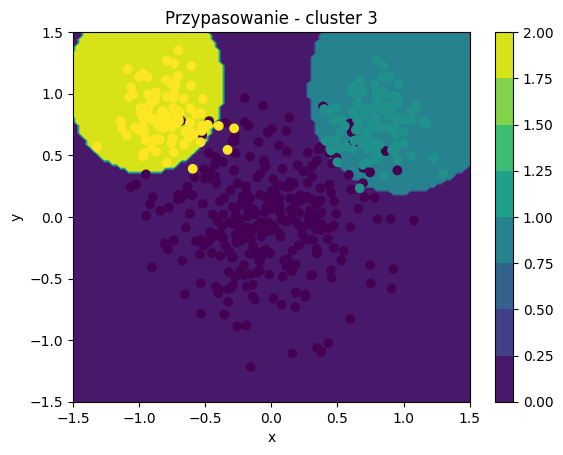

Silhouette score:  0.4631361544986543
Inertia:  89.56313737046148


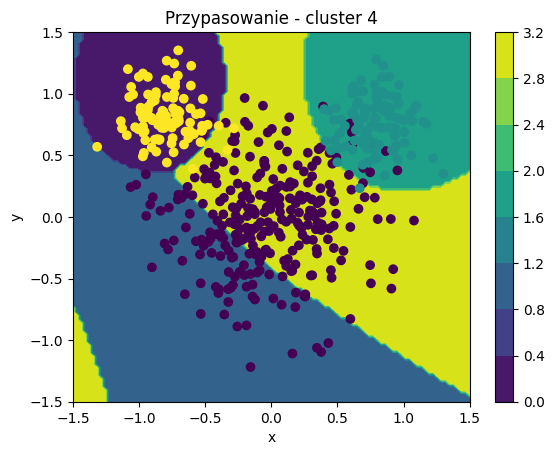

Silhouette score:  0.40052962444089235
Inertia:  68.94829679231009


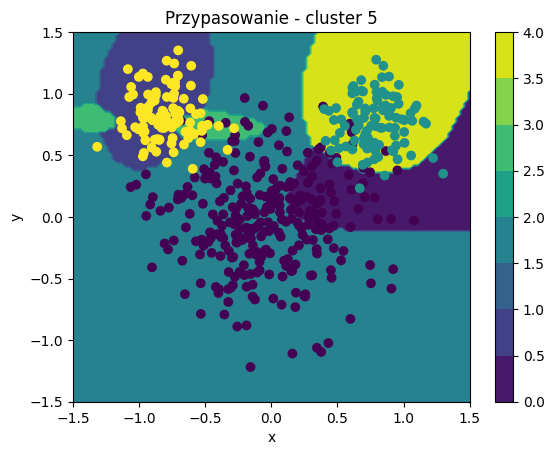

Silhouette score:  0.23430217436356862
Inertia:  67.66849549720249


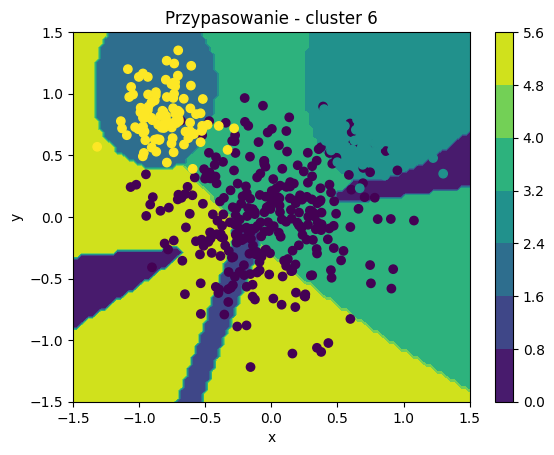

Silhouette score:  0.28782623275254293
Inertia:  61.191834469579156


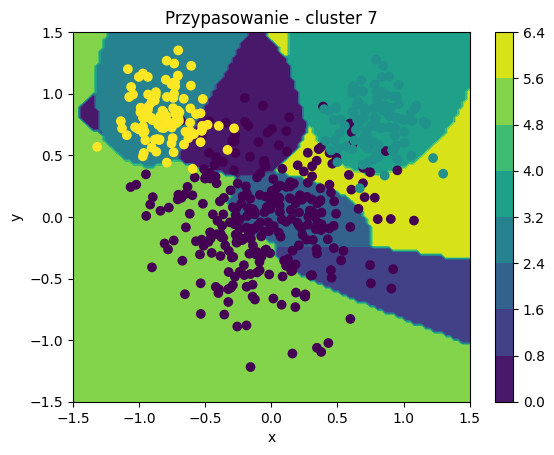

Silhouette score:  0.2961323504464106
Inertia:  43.63083626355983


In [ ]:
Ks=range(2,8)
sllhouetts=[]
inertias=[]

for K in Ks:
  pi = np.ones(K) / K
  mu = np.random.randn(K, d)
  Sigma = np.array([np.eye(d) for _ in range(K)])
  for i in range(100):
      resp = e_step(data_X, pi, mu, Sigma)
      pi, mu, Sigma = m_step(data_X, resp)


  x=np.linspace(-1.5,1.5,100)
  y=np.linspace(-1.5,1.5,100)
  X,Y=np.meshgrid(x,y)
  resps=[]

  for i in range(K):
    Z=np.zeros([len(y),len(x)])
    for j in range(len(x)):
      for k in range(len(y)):
        Z[k,j]=pi[i] *gaussian_pdf(np.array([x[j],y[k]]), mu[i], Sigma[i])
    resps.append(Z)

  przypasowanie=np.argmax(resps,axis=0)
  prawda=[0]*300+[1]*100+[2]*100
  plt.contourf(X,Y,przypasowanie)
  plt.colorbar()
  plt.scatter(data_X[:,0],data_X[:,1],c=prawda,cmap='viridis')
  plt.title('Przypasowanie - cluster '+str(K))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  klasteryzacja=np.argmax(resp,axis=1)
  print('Silhouette score: ', silhouette_score(data_X, klasteryzacja))
  sllhouetts.append(silhouette_score(data_X, klasteryzacja))
  print('Inertia: ', inertia(data_X, klasteryzacja, mu))
  inertias.append(inertia(data_X, klasteryzacja, mu))


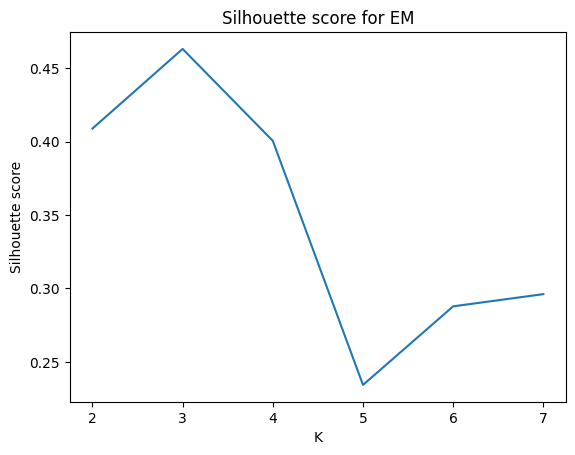

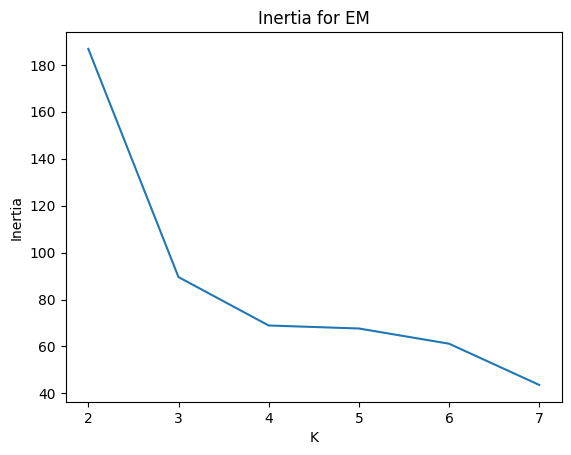

In [ ]:
plt.plot(Ks,sllhouetts)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for EM')
plt.show()

plt.plot(Ks,inertias)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia for EM')
plt.show()

As we can see from plots above the best number of clusters is 3 because it gives the best silhouette score and gives the biggest difference in inertia compared to inertia for 2 clusters.

What is interesting is that for 6 and 7 clusters silhouette scores rise. I think that's because as we can see for 5 clusters second cluster is much bigger and it makes less diversification than 6,7 clusters.

### KMeans

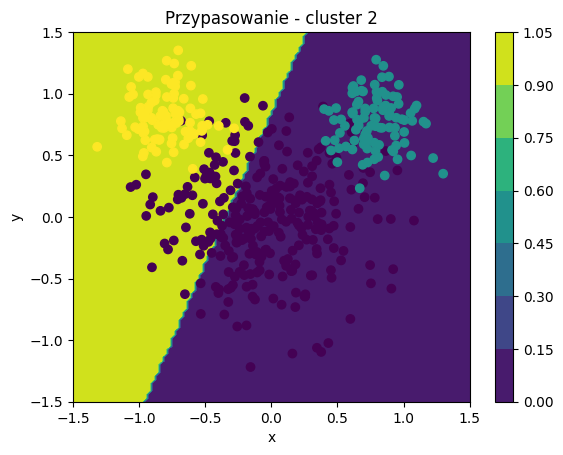

Silhouette score:  0.40010485023311254
Inertia:  184.03241810185096


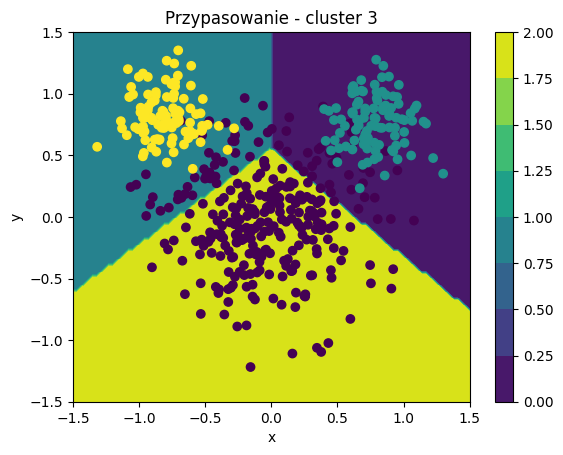

Silhouette score:  0.5152849245204603
Inertia:  82.21576480547022


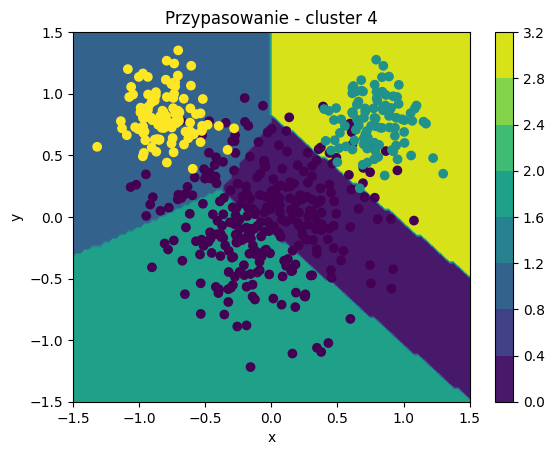

Silhouette score:  0.4499990233162018
Inertia:  63.85233268322616


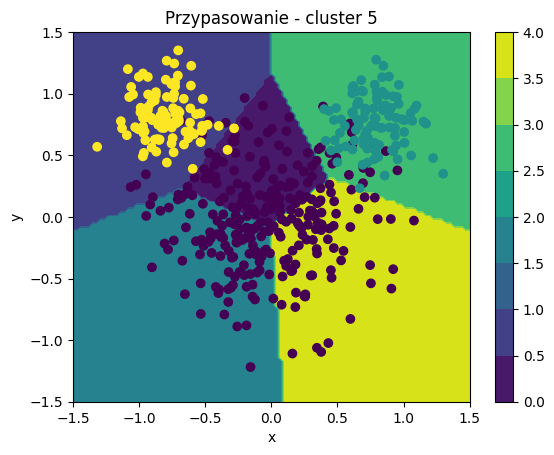

Silhouette score:  0.4381735966786797
Inertia:  52.11876054120289


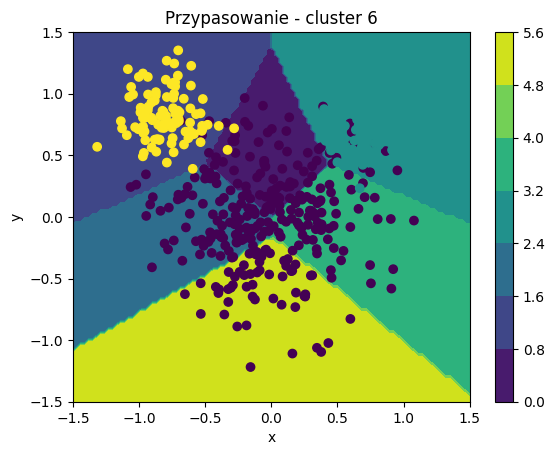

Silhouette score:  0.43322922278213943
Inertia:  43.35172501696859


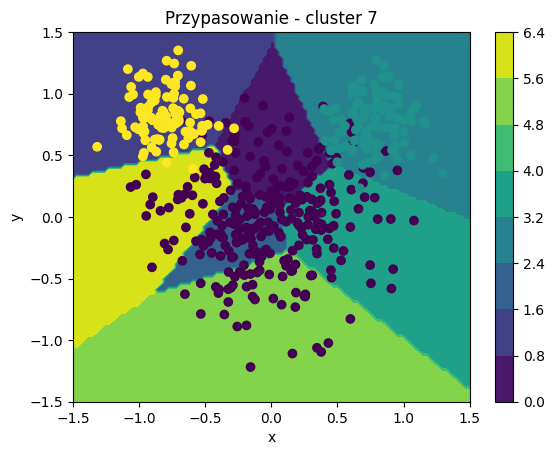

Silhouette score:  0.4220494818689212
Inertia:  38.3964435643728


In [ ]:
from sklearn.cluster import KMeans

Ks=range(2,8)
sllhouetts=[]
inertias=[]

for K in Ks:

  km_model = KMeans(n_clusters=K, random_state=42)
  km_model.fit(data_X)
  km_labels = km_model.labels_
  km_centroids = km_model.cluster_centers_


  x=np.linspace(-1.5,1.5,100)
  y=np.linspace(-1.5,1.5,100)
  X,Y=np.meshgrid(x,y)


  grid=np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
  przypasowanie=km_model.predict(grid).reshape(len(y),len(x))

  prawda=[0]*300+[1]*100+[2]*100
  plt.contourf(X,Y,przypasowanie)
  plt.colorbar()
  plt.scatter(data_X[:,0],data_X[:,1],c=prawda,cmap='viridis')
  plt.title('Przypasowanie - cluster '+str(K))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  print('Silhouette score: ', silhouette_score(data_X, km_labels))
  sllhouetts.append(silhouette_score(data_X, km_labels))
  print('Inertia: ', inertia(data_X, km_labels, km_centroids))
  inertias.append(inertia(data_X, km_labels, km_centroids))




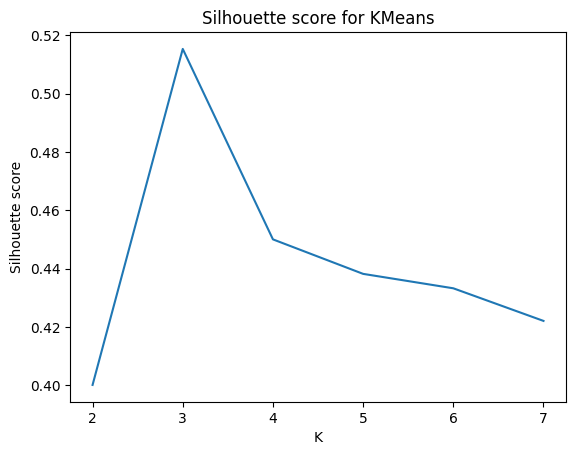

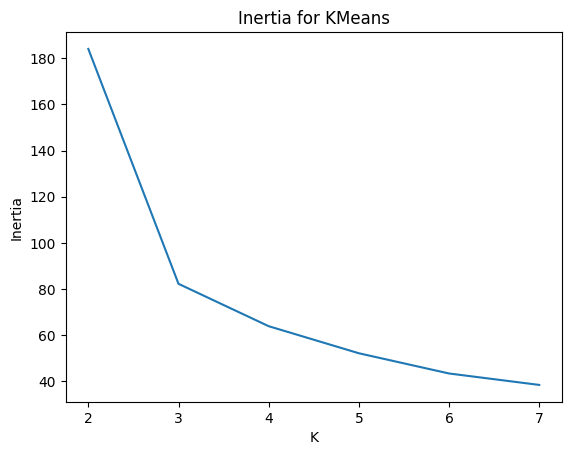

In [ ]:
plt.plot(Ks,sllhouetts)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for KMeans')
plt.show()

plt.plot(Ks,inertias)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia for KMeans')
plt.show()

Just like in the EM example we can see that 3 clusters are the best. However we can't see any rise in silhouette score after 3 clusters.